<a href="https://colab.research.google.com/github/soohyoen/artificial-intelligence/blob/main/%EB%B9%85%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_dacon_Covid_Insight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 코로나 : 시각화를 통한 인사이트 도출

**참고 팀**: https://visualisingkorea.com/

### 1. 준비.

In [40]:
!git clone https://github.com/soohyoen/artificial-intelligence.git

fatal: destination path 'artificial-intelligence' already exists and is not an empty directory.


In [1]:
# 필요한 라이브러리를 가져온다.
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# Pandas 데이터 프레임에서 float을 소수점 2자리 까지 출력해 준다.
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("precision",4)

In [3]:
# 성가신 경고를 꺼준다.
import warnings  
warnings.filterwarnings('ignore')

In [5]:
# 환자정보 데이터를 불러온다.
df1 = pd.read_csv(r'/content/PatientInfo.csv')

In [6]:
df1.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [7]:
# 컬럼의 자료형을 살펴본다.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          4004 non-null   int64  
 1   global_num          2806 non-null   float64
 2   sex                 3674 non-null   object 
 3   birth_year          3267 non-null   object 
 4   age                 3525 non-null   object 
 5   country             4004 non-null   object 
 6   province            4004 non-null   object 
 7   city                3926 non-null   object 
 8   disease             18 non-null     object 
 9   infection_case      3211 non-null   object 
 10  infection_order     31 non-null     float64
 11  infected_by         899 non-null    object 
 12  contact_number      680 non-null    object 
 13  symptom_onset_date  535 non-null    object 
 14  confirmed_date      4001 non-null   object 
 15  released_date       1508 non-null   object 
 16  deceas

### 2. 기초적인 탐색.

In [8]:
# 중복된 환자 ID는 없어 보인다.
print("데이터 행의 수 = {}".format(df1.shape[0]))                  # 데이터 행의 수 = 4004
print("고유한 환자 ID 수 = {}".format(df1.patient_id.nunique()))   # 고유한 환자 ID 수 = 4004

데이터 행의 수 = 4004
고유한 환자 ID 수 = 4004


In [10]:
# 결측치의 총 카운트. 
df1.isnull().sum().sum()

27910

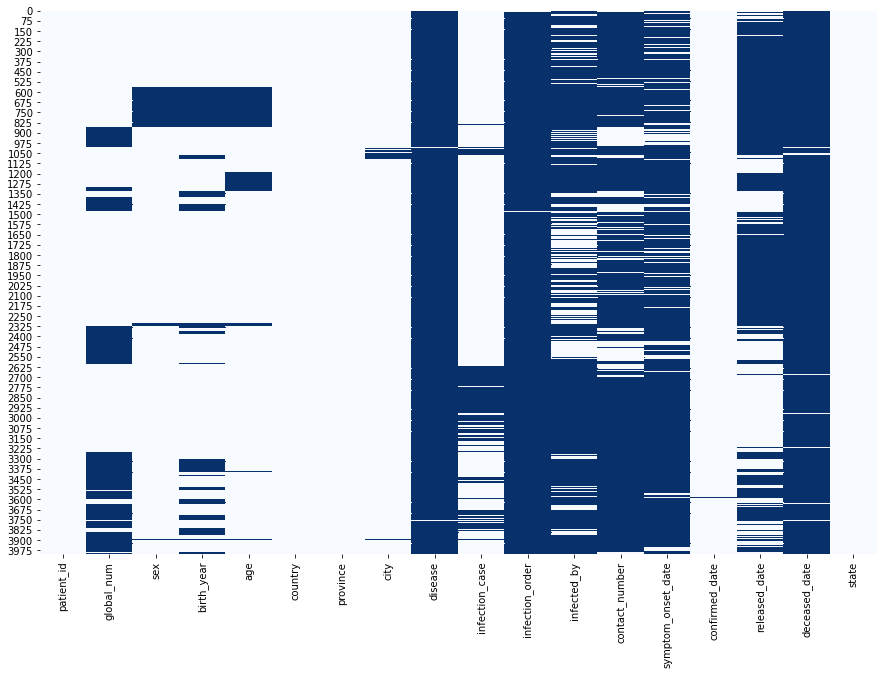

In [16]:
# 결측치를 시각화 해본다.
plt.figure(figsize = (15,10))                                       # figsize=(가로, 세로) 크기.
sns.heatmap(df1.isnull(), cmap='Blues', cbar=False)
plt.show()

In [17]:
df1.age.unique()

array(['50s', '30s', '20s', '60s', '80s', '70s', '40s', '10s', '90s',
       '0s', nan, '30', '100s'], dtype=object)

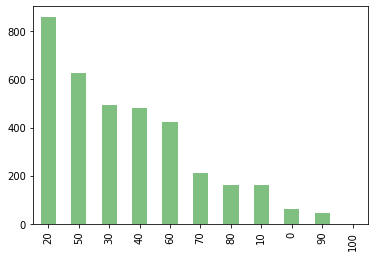

In [21]:
# 명목형 변수인 Age를 시각화 해본다. (연령 집계)
df1.age = df1.age.str.replace('s','',regex=True)                      # 's' 제거.
age_counts = df1.age.value_counts()                                   # 도수표.
age_counts = age_counts.sort_values(ascending=False)                  # 크기가 큰 순서대로 sort
age_counts.plot.bar(color='green', alpha=0.5)
plt.show()

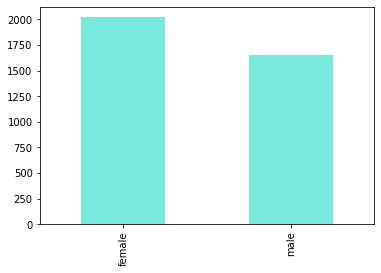

In [18]:
# 명목형 변수인 Sex를 시각화 해본다.(성별집계)
sex_counts = df1.sex.value_counts()              
sex_counts = sex_counts.sort_values(ascending=False)
sex_counts.plot.bar(color='turquoise', alpha=0.7)
plt.show()

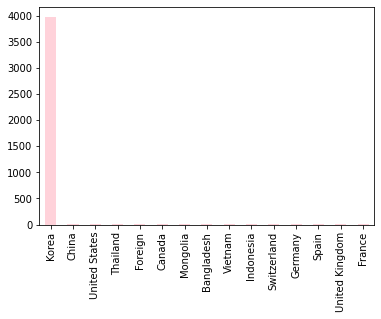

In [22]:
# 명목형 변수인 Country를 가지고 내국인 여부를 시각화 해본다.
country_counts = df1.country.value_counts()                 # 내국인 = True.
country_counts = country_counts.sort_values(ascending=False)
country_counts.plot.bar(color='pink', alpha = 0.7)
plt.show()  

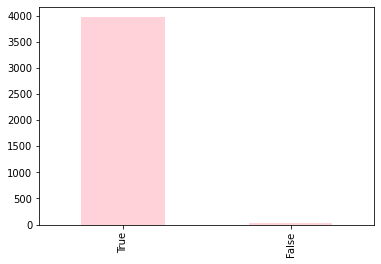

In [23]:
# 한국인만 
country_counts = (df1.country=='Korea').value_counts()                 # 내국인 = True.
country_counts = country_counts.sort_values(ascending=False)
country_counts.plot.bar(color='pink', alpha = 0.7)
plt.show()

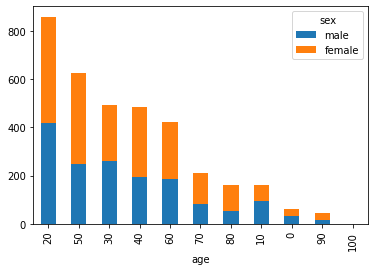

In [24]:
# 명목형 변수인 Age와 Sex를 조합하여 시각화 해본다.
ct = pd.crosstab(df1.age, df1.sex)
ct['total'] = ct.male + ct.female                      # total 컬럼.
ct.sort_values(by=['total'], ascending=False)[['male','female']].plot.bar(stacked=True)   # total로 소팅. total은 시각화에서는 제외!
plt.show()

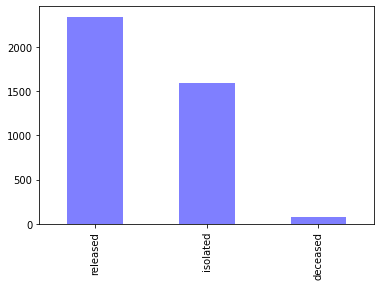

In [25]:
# 명목형 변수인 State를 시각화 해본다.
state_counts = df1.state.value_counts()              
state_counts = state_counts.sort_values(ascending=False)
state_counts.plot.bar(color='blue', alpha=0.5)
plt.show()

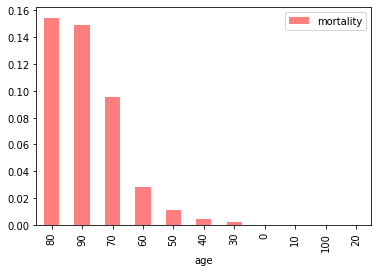

In [26]:
# Age별 사망비율.
ct = pd.crosstab(df1.age, df1.state=='deceased')
ct.columns = ['alive','deceased']
ct['mortality'] = ct.deceased/(ct.alive + ct.deceased)
ct.sort_values(by=['mortality'], ascending=False)[['mortality']].plot.bar(color='red', alpha=0.5)   # mortality로 소팅 및 시각화. (mortality로 sort)
plt.show()

In [29]:
# Age와 사망여부 독립성 검정.
stat, p_val, degFree, expected = st.chi2_contingency(ct[['alive','deceased']])    # 통계량, p-값, 자유도, 기대도수.
print("p_value : {}".format(np.round(p_val,3)))                                   # 독립이 아님!

p_value : 0.0


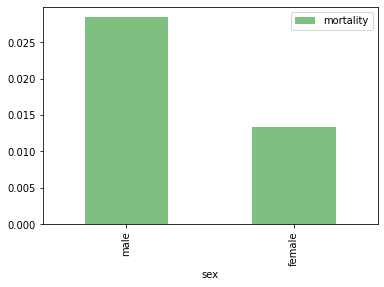

In [30]:
# Sex별 사망비율.
ct = pd.crosstab(df1.sex, df1.state=='deceased')
ct.columns = ['alive','deceased']
ct['mortality'] = ct.deceased/(ct.alive + ct.deceased)
ct.sort_values(by=['mortality'], ascending=False)[['mortality']].plot.bar(color='green', alpha=0.5)   # mortality로 소팅 및 시각화.
plt.show()

In [31]:
# Sex와 사망여부 독립성 검정.
stat, p_val, degFree, expected = st.chi2_contingency(ct[['alive','deceased']])    # 통계량, p-값, 자유도, 기대도수.
print("p_value : {}".format(np.round(p_val,3)))                                   # 독립이 아님!

p_value : 0.002


In [32]:
# 기저질환 (disease)는 결측치 아닌 정상값의 수가 절대적으로 부족해서 분석하기 어려움.
df1.disease.count()

18

### 3. 감염 경로 유형 (Infection Case)

In [33]:
# 감염 경로의 유형 출력.
print(df1.infection_case.unique())

['overseas inflow' 'contact with patient' 'Seongdong-gu APT' 'etc'
 "Eunpyeong St. Mary's Hospital" 'Shincheonji Church' 'Dongan Church'
 'Guro-gu Call Center' nan 'Itaewon Clubs' 'Samsung Medical Center'
 'Coupang Logistics Center' 'Guri Collective Infection'
 'KB Life Insurance' 'Yeongdeungpo Learning Institute' 'Onchun Church'
 'Cheongdo Daenam Hospital' 'Suyeong-gu Kindergarten'
 'Ministry of Oceans and Fisheries' 'gym facility in Cheonan'
 'gym facility in Sejong' 'River of Grace Community Church'
 'Gyeongsan Seorin Nursing Home' 'Gyeongsan Cham Joeun Community Center'
 'Gyeongsan Jeil Silver Town' 'Bonghwa Pureun Nursing Home'
 'Pilgrimage to Israel' 'Milal Shelter' 'Geochang Church'
 'Changnyeong Coin Karaoke']


In [34]:
# 감염 경로의 가지수 출력.
print(df1.infection_case.nunique())

29


In [35]:
# 감염 경로별 환자수 집계하여 시각화 한다.
res = df1.groupby(['infection_case'])['patient_id'].count()        # 결측치가 아닌 patient_id의 수 = 환자의 수.
res = res.reset_index()                                           # Series => DataFrame. 이전의 Index가 이제는 새로운 컬럼!
res.rename(columns = {'infection_case':'infection case', 'patient_id': 'count'}, inplace = True)     # 'patient_id' 컬럼명을 'count'로 변경.
res = res.sort_values(by = 'count', ascending = False)            # 데이터 프레임 내림 차순으로 소팅.
res

,infection case,count
24,contact with patient,1182
28,overseas inflow,703
25,etc,601
12,Itaewon Clubs,156
8,Guro-gu Call Center,112
21,Shincheonji Church,107
3,Coupang Logistics Center,70
16,Onchun Church,33
0,Bonghwa Pureun Nursing Home,31
26,gym facility in Cheonan,30


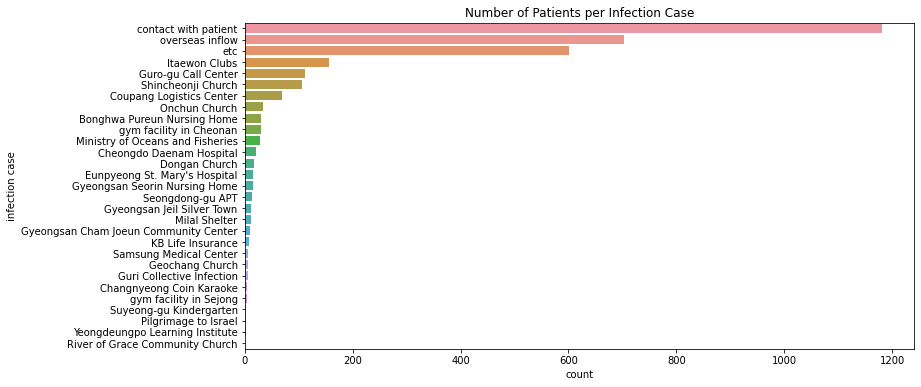

In [36]:
# 감염 경로별 환자수 집계하여 시각화 한다.
res = df1.groupby(['infection_case'])['patient_id'].count()        # 결측치가 아닌 patient_id의 수 = 환자의 수.
res = res.reset_index()                                           # Series => DataFrame. 이전의 Index가 이제는 새로운 컬럼!
res.rename(columns = {'infection_case':'infection case', 'patient_id': 'count'}, inplace = True)     # 'patient_id' 컬럼명을 'count'로 변경.
res = res.sort_values(by = 'count', ascending = False)            # 데이터 프레임 내림 차순으로 소팅.

plt.figure(figsize = (12,6))                                       # figsize=(가로, 세로) 크기.
sns.barplot(y = 'infection case', x= 'count', data = res)
plt.title('Number of Patients per Infection Case')
plt.show()

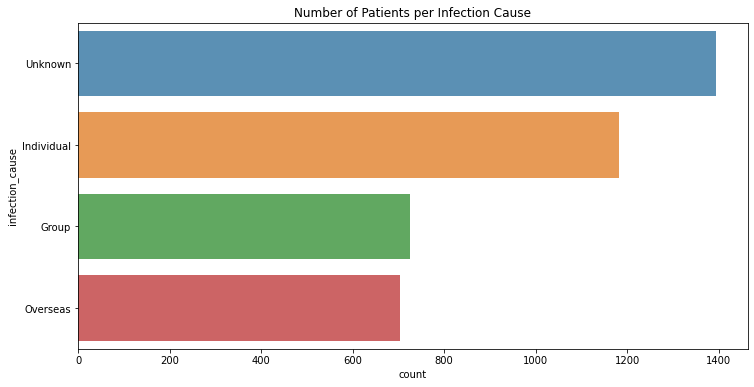

In [37]:
# 다음과 같이 유형의 label을 바꾸어서 다시 집계 및 시각화 해본다.
# 'contact with patient' => 'Individual'     개인접촉
# 'etc'  or NaN         => 'Unknown'         모름
# 'overseas inflow'     => 'Overseas'        해외
#  나머지               => 'Group'            집단

my_dict = {'contact with patient':'Individual', 'etc':'Unknown', 'overseas inflow': 'Overseas'}
res = df1.infection_case.apply(lambda x: my_dict[x] if x in my_dict.keys() else 'Group' if not pd.isnull(x) else 'Unknown')  # 변환! Pythonic! 
# ---> 오른쪽부터 읽고 오른쪽이 충족되면 그 뒤에것을 반환 뒤의 if else, 앞의 if else순서

df1['infection_cause'] = res                                                          # 변환을 df1에도 적용.
res = res.value_counts().sort_values(ascending=False)
res = res.reset_index()                                                               # Series => DataFrame. 이전의 Index가 이제는 새로운 컬럼!
res.rename(columns={'index':'infection_cause','infection_case':'count'},inplace=True)

plt.figure(figsize = (12,6))                                       # figsize=(가로, 세로) 크기.
sns.barplot(y = 'infection_cause', x= 'count', data = res, alpha=0.8)
plt.title('Number of Patients per Infection Cause')
plt.show()

**결론**: 유입 경로를 4가지로 요약해 봄.

### 4. 유동성 (Mobility Level)

In [ ]:
# 새롭게 유입경로 데이터를 불러온다.
df2 = pd.read_csv(r'.\data\PatientRoute.csv')

In [ ]:
df2.head()

In [ ]:
# 결측치의 총 카운트.
df2.isnull().sum().sum()

In [ ]:
# 결측치를 시각화 해본다.
plt.figure(figsize = (10,10))                                       # figsize=(가로, 세로) 크기.
sns.heatmap(df2.isnull(), cmap='Blues', cbar=False)
plt.show()

In [ ]:
# 중복된 환자 ID가 많아 보인다.
print("데이터 행의 수 = {}".format(df2.shape[0]))
print("고유한 환자 ID 수 = {}".format(df2.patient_id.nunique()))

In [ ]:
# 이동 경로의 유형 출력.
print(format(df2.type.unique()))

In [ ]:
# 이동 경로의 가지수 출력.
print(format(df2.type.nunique()))

In [ ]:
# 이동 경로의 유형을 카테고리로 표현해 본다.
leisure = ['library', 'theater', 'cafe', 'bakery', 'beauty_salon',
          'pc_cafe', 'billiards','restaurant', 'bar', 'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['primary_school', 'school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'mountain', 'park']
essential_admin = ['administrative_area_level_1', 'governmnet_office', 'post_office']
non_essential_admin = ['police_office', 'bank', 'real_estate_agency']
necessity = ['store', 'public_transportation', 'gas_station']
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

In [ ]:
# "필수적" 카테고리는 다음과 같이 정의한다.
essential = essential_edu + essential_admin + necessity + medical 
len(essential)

In [ ]:
# 필수/부수적 여부 변수 'is_essential' 파생변수로 추가.
def isessential(x):     
    if x in essential: 
        res = True
    else:
        res = False 
    return res
df2['is_essential'] = df2['type'].apply(lambda x: isessential(x)) 

# 데이터 프레임 간추리기.
df2 = df2[['patient_id', 'type', 'is_essential']]
df2.head()

In [ ]:
# 동일 환자의 경로 유형을 집계한다 (sum).
# 결측치는 0으로 채운다.
df2['route_value'] = 1       # 1 로 채워진 컬럼을 추가해서 집계의 목적으로 사용한다.
df3 = pd.pivot_table(data=df2, index = 'patient_id', columns = 'is_essential', values= 'route_value', aggfunc='sum', fill_value=0)
df3.head()

In [ ]:
# Index로 있는 patient_id를 컬럼으로 빼내고 정리한다.
df3.columns.name=None
df3 = df3.reset_index()
df3 = df3.rename(columns={False:'non_essential',True:'essential'})
df3.head()

In [ ]:
# df1 (PatientInfo)와 df3 (PatientRoute 요약)을 Inner Join 해서 가로 방향으로 붙여서 df_joined를 만든다.
df_joined = df1.merge(df3, left_on = 'patient_id', right_on = 'patient_id' , how='inner')

In [ ]:
# 살펴본다.
df_joined.head()

In [ ]:
# 모든 환자에 대해서 동선이 명확한 것이 아니기 때문에 Join 후 대폭 행의 수가 줄어 들었다.
print("Number of Rows Before = {}".format(len(df1)))
print("Number of Rows After = {}".format(len(df_joined)))

### 5. 접촉 빈도 (Number of Contacts)

In [ ]:
# contact_number가 결측치가 아니고 '-'가 아닌 행들만 가져온다. '-'는 오류로 유입된 값인듯.
res = df_joined.contact_number
df_joined = df_joined[~res.isnull() & (res != '-')]

In [ ]:
# contact_number의 자료형을 integer로 변경하고 이상값은 제거한다.
df_joined['contact_number'] = df_joined.contact_number.astype(int)
df_joined = df_joined[df_joined.contact_number < 10000]

In [ ]:
# 최대 첩촉빈도.
df_joined.contact_number.max()

In [ ]:
# 최대 첩촉빈도에 해당하는 환자.
df_joined[df_joined.contact_number == df_joined.contact_number.max()]

In [ ]:
# 필요한 컬럼만 가져와서 정리한다.
df4 = df_joined[['patient_id', 'contact_number', 'essential','non_essential','infection_cause']]
df4.head()

In [ ]:
# 접촉 빈도를 히스토그램으로 시각화 한다.
sns.distplot(df4.contact_number,bins=50)
plt.show()

### 6. 군집화 (Clustering)

In [ ]:
# Infection_cause를 가변수 처리한다.
df4 = df4.join(pd.get_dummies(df4.infection_cause, prefix='infection',drop_first=False))

In [ ]:
df4

In [ ]:
df_final = df4[ ['essential', 'non_essential', 'contact_number',
          'infection_Group', 'infection_Individual', 'infection_Overseas', 'infection_Unknown']]

In [ ]:
df_final

In [ ]:
# 컬럼의 표준화를 실행한다.
X = df_final.values                        
my_scaler = StandardScaler()
X = my_scaler.fit_transform(X)

In [ ]:
# 군집의 수 = 4로 정하고 군집화를 실행한다.  <= 군집의 수 최적화가 선행되어야 한다! (부록 참고)
my_km = KMeans(n_clusters = 4, random_state = 123)
my_km.fit(X)

my_centroids = my_km.cluster_centers_               # 개개 군집의 중심점.
my_cluster_labels = my_km.labels_                   # 군집 label.

In [ ]:
# 클러스터 중심을 출력하고 해석한다.
pd.DataFrame(my_centroids,columns = df_final.columns)

**해석:** <br>
- Label 0 (red): Social minimalists.
- Label 1 (blue): Hyper-mobile and hyper-social.
- Label 2 (green): Overseas non-essentialists. 
- Label 3 (yellow): Moderate unknwons.

In [ ]:
# PCA 차원축소 (2차원).
my_pca = PCA(n_components = 2)
transformed_comps = my_pca.fit_transform(X)         # Transformed 된 좌표.
df_transformed_comps = pd.DataFrame(data = transformed_comps, columns = ['PC1', 'PC2'])
df_transformed_comps=df_transformed_comps.join(pd.Series(my_cluster_labels, name='cluster_label'))
df_transformed_comps

In [ ]:
# 산점도 시각화.
my_colors = {0:'red',1:'blue',2:'green',3:'yellow'}    # 군집 label => Color.
my_names = {0: 'Social minimalists.', 1: 'Hyper-mobile and hyper-social.' , 2: 'Overseas non-essentialists.', 3: 'Moderate unknwons.'} # 군집 label => 명칭.

plt.figure(figsize = (6,6))
for a_cluster_n, df_small in df_transformed_comps.groupby('cluster_label'):
    plt.scatter('PC1', 'PC2', data = df_small, c = my_colors[a_cluster_n], label = my_names[a_cluster_n], s = 10, alpha=0.6 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters')
plt.legend(loc=4)
plt.show()

### 부록: 군집의 수 최적화

In [ ]:
# 군집의 수를 키워가며 Sum of Squares Within을 계산한다.
ssw = []
cluster_ns = range(2,16)
for n in cluster_ns:
    my_cluster = KMeans(n)
    my_cluster.fit(X)
    ssw += [my_cluster.inertia_]         # SSW를 모아둔다.

plt.figure(figsize = (6,6))
plt.plot(cluster_ns, ssw)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares Within')
plt.show()

**결론**: 군집의 수가 5 이상일 때 SSW의 감소 속도가 둔화된다. => 군집의 적정 수 = 4.